In [1]:
from google.colab import drive
import os


drive.mount('/content/drive')


dataset_path = '/content/drive/MyDrive/dogs-data/'  # Change this to your dataset folder path


Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import xml.etree.ElementTree as ET
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


annotations_path = os.path.join(dataset_path, 'annotations', 'Annotation')
images_path = os.path.join(dataset_path, 'images', 'Images')


def load_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img


def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    object_tag = root.find('object')
    breed = object_tag.find('name').text
    return breed


def find_annotation(annotation_folder, image_filename):
    base_name = image_filename.replace('.jpg', '')

    for file_name in os.listdir(annotation_folder):
        if file_name.startswith(base_name):
            return os.path.join(annotation_folder, file_name)
    return None


image_list = []
label_list = []


for breed_folder in os.listdir(images_path):
    annotation_folder = os.path.join(annotations_path, breed_folder)
    image_folder = os.path.join(images_path, breed_folder)


    if os.path.isdir(annotation_folder) and os.path.isdir(image_folder):
        for file_name in os.listdir(image_folder):
            if file_name.endswith('.jpg'):

                image_path = os.path.join(image_folder, file_name)


                annotation_file = find_annotation(annotation_folder, file_name)


                print(f"Image Path: {image_path}")
                print(f"Annotation Path: {annotation_file}")


                if annotation_file and os.path.exists(annotation_file):

                    image = load_image(image_path)


                    breed = parse_annotation(annotation_file)


                    image_list.append(image)
                    label_list.append(breed)
                else:
                    print(f"Annotation file not found for {file_name}, skipping this image...")
    else:
        print(f"Annotation or image folder not found for {breed_folder}, skipping this breed...")


X = np.array(image_list)
y = np.array(label_list)


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)


X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')
print(f'Number of classes: {len(label_encoder.classes_)}')


Streaming output truncated to the last 5000 lines.
Image Path: /content/drive/MyDrive/dogs-data/images/Images/n02113799-standard_poodle/n02113799_3278.jpg
Annotation Path: /content/drive/MyDrive/dogs-data/annotations/Annotation/n02113799-standard_poodle/n02113799_3278
Image Path: /content/drive/MyDrive/dogs-data/images/Images/n02113799-standard_poodle/n02113799_1155.jpg
Annotation Path: /content/drive/MyDrive/dogs-data/annotations/Annotation/n02113799-standard_poodle/n02113799_1155
Image Path: /content/drive/MyDrive/dogs-data/images/Images/n02113799-standard_poodle/n02113799_489.jpg
Annotation Path: /content/drive/MyDrive/dogs-data/annotations/Annotation/n02113799-standard_poodle/n02113799_489
Image Path: /content/drive/MyDrive/dogs-data/images/Images/n02113799-standard_poodle/n02113799_3945.jpg
Annotation Path: /content/drive/MyDrive/dogs-data/annotations/Annotation/n02113799-standard_poodle/n02113799_3945
Image Path: /content/drive/MyDrive/dogs-data/images/Images/n02113799-standard_p

In [3]:
num_classes = len(label_encoder.classes_)

In [4]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (16464, 224, 224, 3)
Shape of X_test: (4116, 224, 224, 3)


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pretrained MobileNetV2 model without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (to retain the pre-trained weights)
base_model.trainable = True

# Build the new model on top of the pretrained base
model = Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Print summary of the model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          15,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,301,752 (39.30 MB)

 Trainable params: 10,267,640 (39.17 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=15,
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


515/515 ━━━━━━━━━━━━━━━━━━━━ 246s 375ms/step - accuracy: 0.0140 - loss: 5.0207 - val_accuracy: 0.0931 - val_loss: 4.3339
Epoch 2/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 161s 308ms/step - accuracy: 0.0553 - loss: 4.4439 - val_accuracy: 0.2923 - val_loss: 3.2363
Epoch 3/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 161s 308ms/step - accuracy: 0.1517 - loss: 3.8139 - val_accuracy: 0.4713 - val_loss: 2.3409
Epoch 4/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 160s 306ms/step - accuracy: 0.2538 - loss: 3.2414 - val_accuracy: 0.5792 - val_loss: 1.8032
Epoch 5/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 161s 309ms/step - accuracy: 0.3234 - loss: 2.8597 - val_accuracy: 0.6283 - val_loss: 1.5356
Epoch 6/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 160s 307ms/step - accuracy: 0.3909 - loss: 2.5175 - val_accuracy: 0.6703 - val_loss: 1.3430
Epoch 7/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 160s 307ms/step - accuracy: 0.4308 - loss: 2.3116 - val_accuracy: 0.6970 - val_loss: 1.2072
Epoch 8/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 161s 308ms/step - accuracy: 0.4762 - loss: 2.14

In [8]:
model.save('/content/drive/MyDrive/dogs-data/dog_breed_classifier.h5')

In [19]:
predictions = model.predict(X_test)


# Convert predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculate the accuracy
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)

# Print the accuracy
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Accuracy on the test set: 75.58%


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


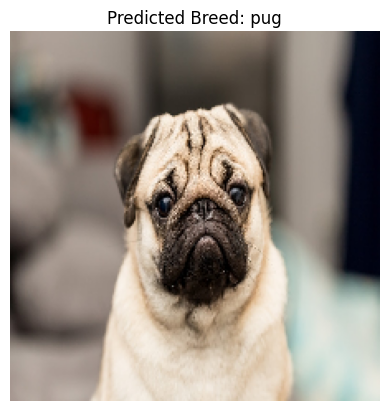

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


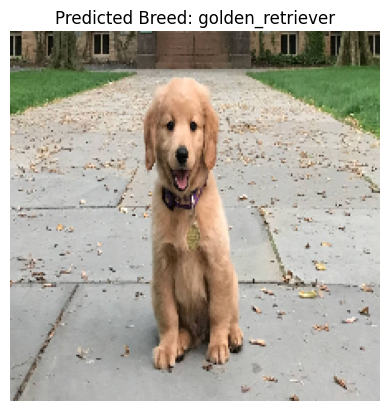

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


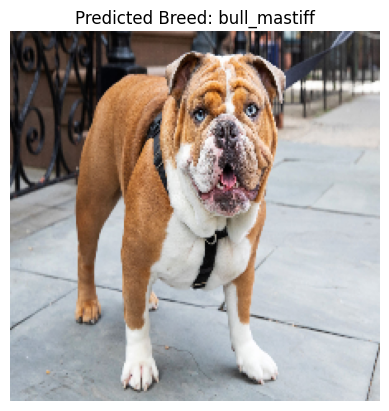

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


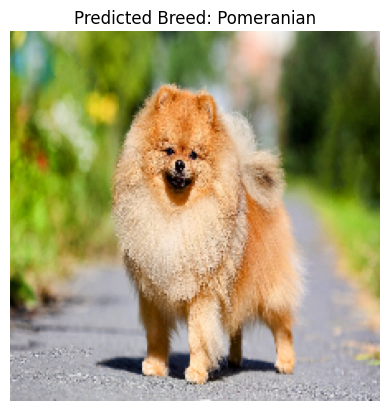

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the test folder in Google Drive
test_folder = '/content/drive/MyDrive/dogs-data/Test/'  # Replace with the actual path

# Function to load and preprocess each image
def load_and_preprocess_image(img_path):
    # Load the image from the given path
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

    # Convert the image to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Normalize the image (same as in training)
    img_array = img_array / 255.0

    # Add an extra dimension to match the model input shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

# Loop over all .jpg files in the test folder
for img_file in os.listdir(test_folder):
    if img_file.endswith('.jpg'):  # Only process .jpg files
        img_path = os.path.join(test_folder, img_file)

        # Load and preprocess the image
        original_img, preprocessed_image = load_and_preprocess_image(img_path)

        # Make predictions using the trained model
        prediction = model.predict(preprocessed_image)

        # Get the predicted class (index) and map it back to the breed name
        predicted_class = np.argmax(prediction)
        predicted_breed = label_encoder.inverse_transform([predicted_class])[0]

        # Display the image and predicted breed
        plt.imshow(original_img)
        plt.axis('off')  # Hide axes for a cleaner look
        plt.title(f"Predicted Breed: {predicted_breed}")
        plt.show()


In [23]:
import pickle

# Save the trained model
model.save('/content/drive/MyDrive/dogs-data/model/dog_breed_model.h5')

# Save the trained label encoder
with open('/content/drive/MyDrive/dogs-data/model/label_encoder.pkl', 'wb') as le_file:
    pickle.dump(label_encoder, le_file)

print("Model and label encoder saved successfully!")

Model and label encoder saved successfully!
